In [0]:
!pip install tflearn

    100% |████████████████████████████████| 102kB 3.7MB/s 
  Running setup.py bdist_wheel for tflearn ... - \ done
  Stored in directory: /content/.cache/pip/wheels/fb/06/72/0478c938ca315c6fddcce8233b80ec91a115ce4496a27e8c90
Successfully built tflearn


In [0]:
from __future__ import division, print_function, absolute_import

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

import os

In [0]:
!pip install pydrive

    100% |████████████████████████████████| 993kB 1.2MB/s 
  Running setup.py bdist_wheel for pydrive ... - done
  Stored in directory: /content/.cache/pip/wheels/ea/bd/b1/14e948c56cce2c7ac1589346cb54d7efb659fa2ddfa6abba88
Successfully built pydrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
from pydrive.drive import GoogleDrive

drive = GoogleDrive(gauth) # Create GoogleDrive instance with authenticated GoogleAuth instance

# Auto-iterate through all files in the root folder.
file_list = drive.ListFile({'q': "'1vQhQXjy4X9woILOTXeY3C-tz14xJkBQE' in parents and trashed=false"}).GetList()
for file1 in file_list:
  if file1['title'] == 'train.pkl':
     PIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))
  elif file1['title'] == 'validation.pkl':
     VALIDPIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))
  elif file1['title'] == 'test.pkl':
     TESTPIK = file1['id']
     print('title: %s, id: %s' % (file1['title'], file1['id']))


title: train.pkl, id: 13rbDW4JpED4Q97AOe1WquZCLCHWb7aI0
title: validation.pkl, id: 1wNCJDiwVMnoIL4alHl9De08b337WiEZP
title: test.pkl, id: 1gSKWAsH9YND3Y3_vNrXeXa-KRiPEGqBS


In [0]:
import pickle

In [0]:
X = []
Y = []
X_validate = []
Y_validate = []
X_test = []
Y_test = []

label_pairs ={
    'adho_mukha_svanasana':1,
    'bharadvajasana':2,
    'pasasana':3,
    'salamba_sarvangasana':4,
    'salamba_sirsasana':5,
    'virabhadrasana_I':6,
    'virabhadrasana_II':7,
    'virabhadrasana_III':8
}


In [0]:
dataFile = drive.CreateFile({'id': PIK}).GetContentFile('train.pkl')

In [0]:
testFile = drive.CreateFile({'id': TESTPIK}).GetContentFile('test.pkl')

In [0]:
validateFile = drive.CreateFile({'id': VALIDPIK}).GetContentFile('validation.pkl')

In [0]:

X_type = 'float64'

with open('train.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X.append(record[0].astype(X_type))
            Y.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Train Data Size :" , len(X))


processing done!
Train Data Size : 6180


In [0]:
with open('validation.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X_validate.append(record[0].astype(X_type))
            Y_validate.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Validation Data Size :" , len(X_validate))

processing done!
Validation Data Size : 1330


In [0]:
with open('test.pkl', "rb") as f:
    while True :
        try:
            record=pickle.load(f)
            X_test.append(record[0].astype(X_type))
            Y_test.append(label_pairs[record[1]])
        except EOFError:
            print('processing done!')
            break
            
print ("Test Data Size :" , len(X_test))


processing done!
Test Data Size : 265


In [0]:
#convert to categorical variables
Y = to_categorical(Y, 9)
Y_validate = to_categorical(Y_validate, 9)
Y_test = to_categorical(Y_test, 9)

from __future__ import division, print_function, absolute_import

# Real-time data preprocessing - normalize the data
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Real-time data augmentation
# Create extra synthetic training data by flipping, rotating and blurring images
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)
img_aug.add_random_crop((64, 64))
img_aug.add_random_blur (sigma_max=5.0)


# Input is a 32x32 image with 3 color channels (red, green and blue)
network = input_data(shape=[None, 64, 64, 3],
                     data_preprocessing=img_prep,
                     data_augmentation=img_aug)

# Step 1: Convolution
network = conv_2d(network, 64, 3, activation='relu')

# Step 2: Max pooling
network = max_pool_2d(network, 2)

# Step 3: Convolution again
network = conv_2d(network, 128, 3, activation='relu')

# Step 4: Convolution yet again
network = conv_2d(network, 128, 3, activation='relu')

# Step 5: Max pooling again
network = max_pool_2d(network, 2)

# Step 6: Convolution yet again
network = conv_2d(network, 128, 3, activation='relu')

# Step 7: Max pooling again
# network = max_pool_2d(network, 2)

# Step 8: Fully-connected 512 node neural network
network = fully_connected(network, 512, activation='relu')

# Step 9: Dropout - throw away some data randomly during training to prevent over-fitting
network = dropout(network, 0.5)

# Step 10: Fully-connected neural network with two outputs (0=isn't a bird, 1=is a bird) to make the final prediction
network = fully_connected(network, 9, activation='softmax')

# Tell tflearn how we want to train the network
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [0]:
model = tflearn.DNN(network)

In [0]:
model_name='conv_nn_v03'

In [0]:
# #Load weights from previous model

# pretrain_model_name = "cifar10_cnn_pretrain"
# # Auto-iterate through all files in the root folder.
# model_parentfolder_id="1Ay8W74_15gHTpEz-SARe-mxXBE-yTKoe"
# file_list = drive.ListFile({'q': "'{parent_id}'".format(parent_id=model_parentfolder_id) + " in parents and trashed=false"}).GetList()
# for file1 in file_list:
#   if file1['title'] == pretrain_model_name :
#     model_dir = drive.ListFile({'q': "'{folderid}' in parents and trashed=false".format(folderid=file1['id'])}).GetList()
#     for file2 in model_dir:
#       drive.CreateFile({'id': file2['id']}).GetContentFile(file2['title']) 
      

# model.load(pretrain_model_name)

In [0]:
# Training

start_time = time.time()

model.fit(X, Y, n_epoch=50, validation_set=(X_validate, Y_validate),
          snapshot_epoch=20, snapshot_step=500,
          show_metric=True, batch_size=64, shuffle=True,
          run_id=model_name)


Training Step: 4849  | total loss: 0.09054 | time: 11.564s
| Adam | epoch: 050 | loss: 0.09054 - acc: 0.9736 -- iter: 6144/6180
Training Step: 4850  | total loss: 0.08667 | time: 12.687s
| Adam | epoch: 050 | loss: 0.08667 - acc: 0.9746 | val_loss: 2.27195 - val_acc: 0.6797 -- iter: 6180/6180
--


In [0]:
 model.save(model_name)
 print("Network trained and saved as "+model_name+" time taken: " , time.time() - start_time)

INFO:tensorflow:/content/conv_nn_v03 is not in all_model_checkpoint_paths. Manually adding it.
Network trained and saved as conv_nn_v03 time taken:  666.7988185882568


In [0]:
def createGoogleDrivefolder(name,parent_id):
  folder=drive.CreateFile({'title': name,'parents':[{"kind": "drive#fileLink", "id": parent_id}],'mimeType': 'application/vnd.google-apps.folder'})
  folder.Upload()
  return folder.get('id')

In [0]:
def uploadFileToGoogleDrive(local_file_dir,name,parentfolder_id):
  file=drive.CreateFile({'title': name,'parents':[{"kind": "drive#fileLink", "id": parentfolder_id}]})
  file.SetContentFile(local_file_dir)
  file.Upload()
  return file.get('id')

In [0]:
#Google Drive Id for project/models folder
model_parentfolder_id="1Ay8W74_15gHTpEz-SARe-mxXBE-yTKoe"
#Name of model folder
source_model_name = model_name
target_model_name = model_name
#Create SubFolder with Model Name in Google Drive
model_folder_id=createGoogleDrivefolder(target_model_name,model_parentfolder_id)
#Create Files with Model Name in Google Drive
for filename in os.listdir('.'):
  if source_model_name in filename:
    print('upload model file with id:'+ filename)
    createGoogleDrivefolder=uploadFileToGoogleDrive('.'+'/'+filename,filename,model_folder_id)

upload model file with id:conv_nn_v03.data-00000-of-00001
upload model file with id:conv_nn_v03.index
upload model file with id:conv_nn_v03.meta


In [0]:
#Predicting

test_images_and_labels = list(zip(X_test, Y_test))
correct_count = 0
wrong_count = 0
correct_indices = []
wrong_indices = []
preds = []
labels = []
total_predict_time = 0 ;

for index, (image, label) in enumerate(test_images_and_labels):
    imagedata = image[np.newaxis, :, :]
    predict_start_time = time.time()
    pred = model.predict(imagedata)
    total_predict_time=total_predict_time+(time.time()-predict_start_time)
    pred = pred[0].argmax(axis=0)
    label = label.argmax(axis=0)
    #print("Pred: {pred} Actual:{label}".format(pred=pred, label=label) )
    #print(int(pred))
    #print(int(label))
    preds = np.append(preds,pred)
    labels = np.append(labels,label)
    if int(pred) == int(label) :
        correct_count=correct_count+1
        correct_indices = np.append(correct_indices,int(index))
    else :
        wrong_count=wrong_count+1
        wrong_indices = np.append(wrong_indices,int(index))

accuracy=correct_count/(correct_count+wrong_count)
print(accuracy)
print(correct_count)
print(wrong_count)
print("Total Prediction Time :" + str(total_predict_time))


0.6792452830188679
180
85
Total Prediction Time :0.9562594890594482


In [0]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
conf_mat = np.matrix(tf.confusion_matrix(labels,preds,num_classes=8,dtype=tf.int32))
conf_mat = confusion_matrix(labels,preds)


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[18  2  1  0  0  1  5  1]
 [ 2 24  3  1  2  1  0  0]
 [ 0  4 16  0  2  1  1  2]
 [ 1  3  0 19  3  1  1  1]
 [ 2  2  1  6 28  2  0  2]
 [ 2  1  0  0  2 27  5  3]
 [ 2  1  0  1  1 11 22  0]
 [ 1  0  0  0  0  1  0 26]]
Confusion matrix, without normalization
[[18  2  1  0  0  1  5  1]
 [ 2 24  3  1  2  1  0  0]
 [ 0  4 16  0  2  1  1  2]
 [ 1  3  0 19  3  1  1  1]
 [ 2  2  1  6 28  2  0  2]
 [ 2  1  0  0  2 27  5  3]
 [ 2  1  0  1  1 11 22  0]
 [ 1  0  0  0  0  1  0 26]]
Normalized confusion matrix
[[0.64285714 0.07142857 0.03571429 0.         0.         0.03571429
  0.17857143 0.03571429]
 [0.06060606 0.72727273 0.09090909 0.03030303 0.06060606 0.03030303
  0.         0.        ]
 [0.         0.15384615 0.61538462 0.         0.07692308 0.03846154
  0.03846154 0.07692308]
 [0.03448276 0.10344828 0.         0.65517241 0.10344828 0.03448276
  0.03448276 0.03448276]
 [0.04651163 0.04651163 0.02325581 0.13953488 0.65116279 0.04651163
  0.         0.04651163]
 [0.05       0.025      0.       

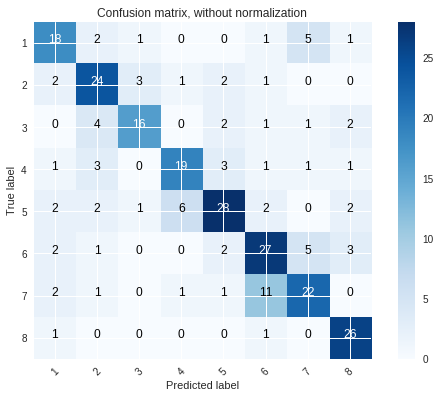

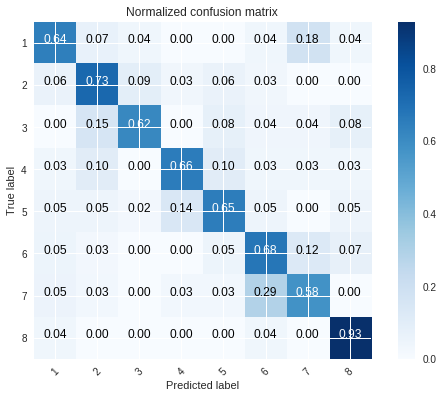

In [0]:
np.set_printoptions(threshold=np.nan)
class_names=['1','2','3','4','5','6','7','8']
print(conf_mat)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()